# Hugging Face transformer library
## Today we will be using Hugging Face instead of Fast AI.

    

In [29]:
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')


In [30]:
!pip install kaggle

In [16]:
creds = ''

In [24]:
# for working with paths in Python, I recommend using `pathlib.Path`
from pathlib import Path

cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)
else:
    print("Kaggle credentials already exist.")

Kaggle credentials already exist.


In [41]:
path = Path('us-patent-phrase-to-phrase-matching')


In [42]:
if not iskaggle and not path.exists():
    print("path does nto exist")
    import zipfile
    import kaggle
    kaggle.api.competition_download_cli('us-patent-phrase-to-phrase-matching')
    zipfile.ZipFile(f'{path}.zip').extractall(path)

path does nto exist


HTTPError: 403 Client Error: Forbidden for url: https://www.kaggle.com/api/v1/competitions/data/download-all/us-patent-phrase-to-phrase-matching

In [ ]:
if iskaggle:
    
    print(path)
    ! pip install -q datasets


Kaggle credentials already exist.


In [45]:
import pandas as pd

In [52]:
path = Path('../kaggle/input/us-patent-phrase-to-phrase-matching')
df = pd.read_csv(path/'train.csv')

In [53]:
df.head(5)

,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00


In [54]:
df.describe(include='object')

,id,anchor,target,context
count,36473,36473,36473,36473
unique,36473,733,29340,106
top,37d61fd2272659b1,component composite coating,composition,H01
freq,1,152,24,2186


In [56]:
df['input'] = 'TEXT1: ' + df.context + '; TEXT2: ' + df.target + '; ANC1: ' + df.anchor
df.input.head()

0    TEXT1: A47; TEXT2: abatement of pollution; ANC...
1    TEXT1: A47; TEXT2: act of abating; ANC1: abate...
2    TEXT1: A47; TEXT2: active catalyst; ANC1: abat...
3    TEXT1: A47; TEXT2: eliminating process; ANC1: ...
4    TEXT1: A47; TEXT2: forest region; ANC1: abatement
Name: input, dtype: object

In [66]:
#%pip install datasets
from datasets import Dataset

ds = Dataset.from_pandas(df)

ds

Dataset({
    features: ['id', 'anchor', 'target', 'context', 'score', 'input'],
    num_rows: 36473
})

In [78]:
model_nm = "distilbert-base-uncased-finetuned-sst-2-english"

from transformers import AutoTokenizer, AutoModelForSequenceClassification
tokz = AutoTokenizer.from_pretrained(model_nm)         # let it pick fast if available
model = AutoModelForSequenceClassification.from_pretrained(model_nm)


In [81]:
from transformers import AutoModelForSequenceClassification,AutoTokenizer
tokz = AutoTokenizer.from_pretrained(model_nm)

In [79]:
tokz = AutoTokenizer.from_pretrained(model_nm, use_fast=True)  # prefer fast tokenizer
# or, if that fails, still slow is fine *if* the repo has tokenizer files:
tokz = AutoTokenizer.from_pretrained(model_nm, use_fast=False)


tokz.tokenize("G'day folks, I'm Jeremy from fast.ai!")

['g',
 "'",
 'day',
 'folks',
 ',',
 'i',
 "'",
 'm',
 'jeremy',
 'from',
 'fast',
 '.',
 'ai',
 '!']

In [82]:
tokz.tokenize("A platypus is an ornithorhynchus anatinus.")

['a',
 'pl',
 '##at',
 '##yp',
 '##us',
 'is',
 'an',
 'or',
 '##ni',
 '##thor',
 '##hy',
 '##nch',
 '##us',
 'ana',
 '##tin',
 '##us',
 '.']

In [83]:
def tok_func(x): return tokz(x["input"])

In [84]:
tok_ds = ds.map(tok_func, batched=True)

Map: 100%|██████████| 36473/36473 [00:00<00:00, 44835.08 examples/s]


In [85]:
row = tok_ds[0]
row['input'], row['input_ids']

('TEXT1: A47; TEXT2: abatement of pollution; ANC1: abatement',
 [101,
  3793,
  2487,
  1024,
  1037,
  22610,
  1025,
  3793,
  2475,
  1024,
  19557,
  18532,
  4765,
  1997,
  10796,
  1025,
  2019,
  2278,
  2487,
  1024,
  19557,
  18532,
  4765,
  102])

In [88]:
tokz.vocab['##of']

11253

In [89]:
tok_ds = tok_ds.rename_columns({'score':'labels'})

In [90]:
eval_df = pd.read_csv(path/'test.csv')
eval_df.describe()

,id,anchor,target,context
count,36,36,36,36
unique,36,34,36,29
top,4112d61851461f60,hybrid bearing,inorganic photoconductor drum,G02
freq,1,2,1,3


In [91]:
def f(x): return -3*x**2 + 2*x + 20

In [92]:
import numpy as np, matplotlib.pyplot as plt

def plot_function(f, min=-2.1, max=2.1, color='r'):
    x = np.linspace(min,max, 100)[:,None]
    plt.plot(x, f(x), color)

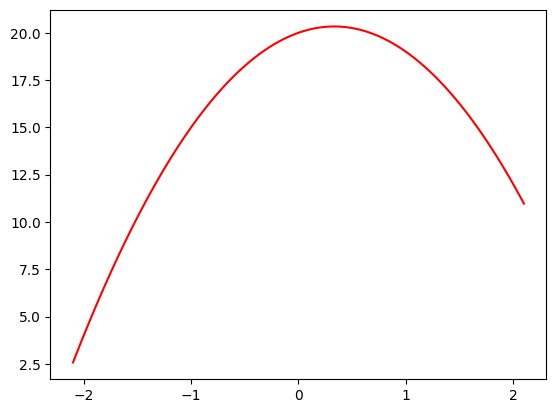

In [93]:
plot_function(f)

In [94]:
from numpy.random import normal,seed,uniform
np.random.seed(42)

In [95]:
def noise(x, scale): return normal(scale=scale, size=x.shape)
def add_noise(x, mult, add): return x * (1+noise(x,mult)) + noise(x,add)

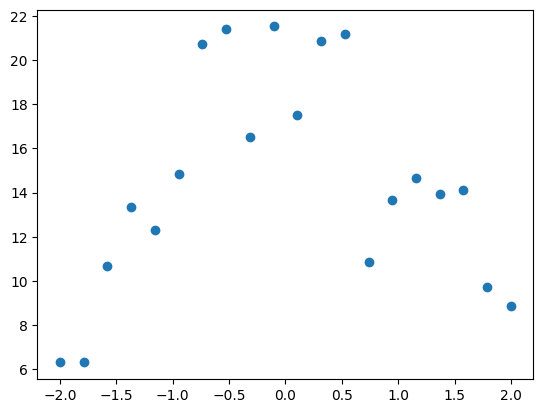

In [96]:
x = np.linspace(-2, 2, num=20)[:,None]
y = add_noise(f(x), 0.2, 1.3)
plt.scatter(x,y);

In [97]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

def plot_poly(degree):
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(x, y)
    plt.scatter(x,y)
    plot_function(model.predict)

# Underfitting

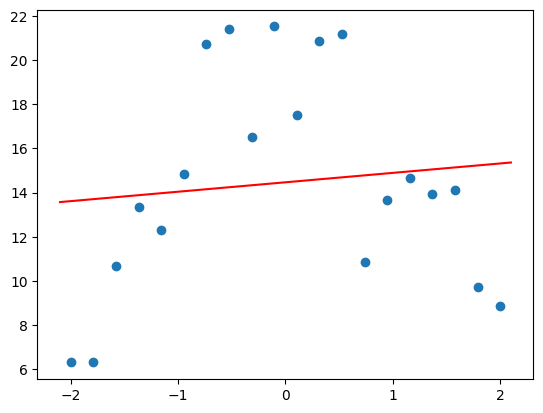

In [116]:
plot_poly(1)

# Over fitting

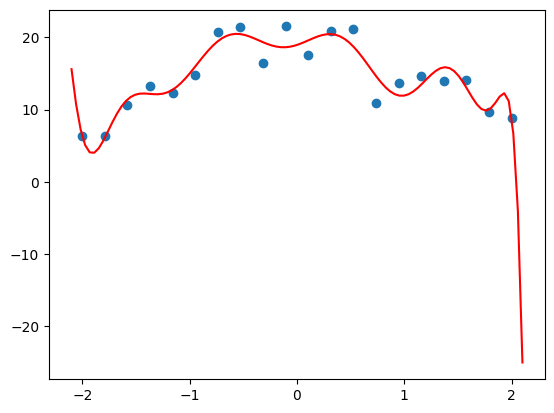

In [119]:
plot_poly(12)



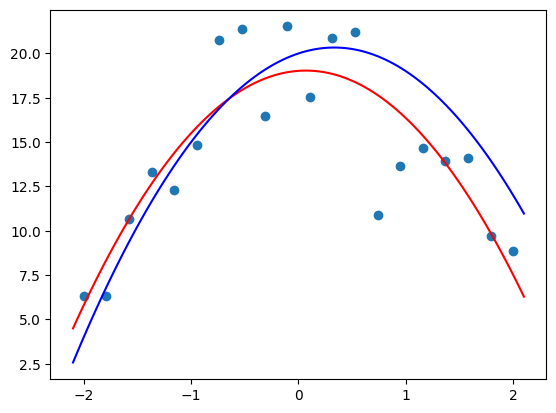

In [120]:
plot_poly(2)
plot_function(f, color='b')

In [124]:
dds = tok_ds.train_test_split(0.25, seed=42)
dds

DatasetDict({
    train: Dataset({
        features: ['id', 'anchor', 'target', 'context', 'labels', 'input', 'input_ids', 'attention_mask'],
        num_rows: 27354
    })
    test: Dataset({
        features: ['id', 'anchor', 'target', 'context', 'labels', 'input', 'input_ids', 'attention_mask'],
        num_rows: 9119
    })
})

In [125]:
dds = tok_ds.train_test_split(0.25, seed=42)

dds["train"]

Dataset({
    features: ['id', 'anchor', 'target', 'context', 'labels', 'input', 'input_ids', 'attention_mask'],
    num_rows: 27354
})

In [126]:
eval_df['input'] = 'TEXT1: ' + eval_df.context + '; TEXT2: ' + eval_df.target + '; ANC1: ' + eval_df.anchor
eval_ds = Dataset.from_pandas(eval_df).map(tok_func, batched=True)

Map: 100%|██████████| 36/36 [00:00<00:00, 8362.59 examples/s]


In [127]:
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing(as_frame=True)
housing = housing['data'].join(housing['target']).sample(1000, random_state=52)
housing.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
7506,3.0550,37.0,5.152778,1.048611,729.0,5.062500,33.92,-118.28,1.054
4720,3.0862,35.0,4.697897,1.055449,1159.0,2.216061,34.05,-118.37,3.453
12888,2.5556,24.0,4.864905,1.129222,1631.0,2.395007,38.66,-121.35,1.057
13344,3.0057,32.0,4.212687,0.936567,1378.0,5.141791,34.05,-117.64,0.969
7173,1.9083,42.0,3.888554,1.039157,1535.0,4.623494,34.05,-118.19,1.192


In [128]:
np.set_printoptions(precision=2, suppress=True)

np.corrcoef(housing, rowvar=False)

array([[ 1.  , -0.12,  0.43, -0.08,  0.01, -0.07, -0.12,  0.04,  0.68],
       [-0.12,  1.  , -0.17, -0.06, -0.31,  0.  ,  0.03, -0.13,  0.12],
       [ 0.43, -0.17,  1.  ,  0.76, -0.09, -0.07,  0.12, -0.03,  0.21],
       [-0.08, -0.06,  0.76,  1.  , -0.08, -0.07,  0.09,  0.  , -0.04],
       [ 0.01, -0.31, -0.09, -0.08,  1.  ,  0.16, -0.15,  0.13,  0.  ],
       [-0.07,  0.  , -0.07, -0.07,  0.16,  1.  , -0.16,  0.17, -0.27],
       [-0.12,  0.03,  0.12,  0.09, -0.15, -0.16,  1.  , -0.93, -0.16],
       [ 0.04, -0.13, -0.03,  0.  ,  0.13,  0.17, -0.93,  1.  , -0.03],
       [ 0.68,  0.12,  0.21, -0.04,  0.  , -0.27, -0.16, -0.03,  1.  ]])

In [129]:
np.corrcoef(housing.MedInc, housing.MedHouseVal)

array([[1.  , 0.68],
       [0.68, 1.  ]])

In [130]:
def corr(x,y): return np.corrcoef(x,y)[0][1]

corr(housing.MedInc, housing.MedHouseVal)

np.float64(0.6760250732906)

In [131]:
def show_corr(df, a, b):
    x,y = df[a],df[b]
    plt.scatter(x,y, alpha=0.5, s=4)
    plt.title(f'{a} vs {b}; r: {corr(x, y):.2f}')

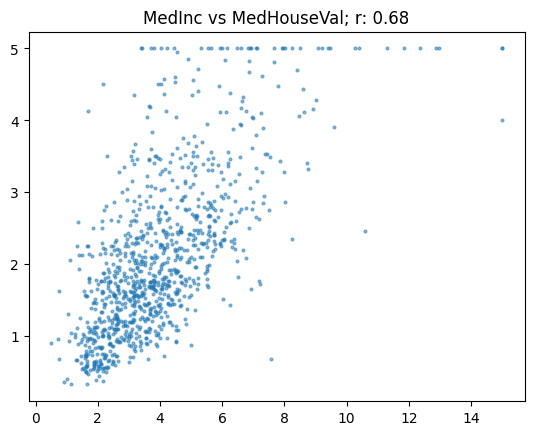

In [132]:
show_corr(housing, 'MedInc', 'MedHouseVal')

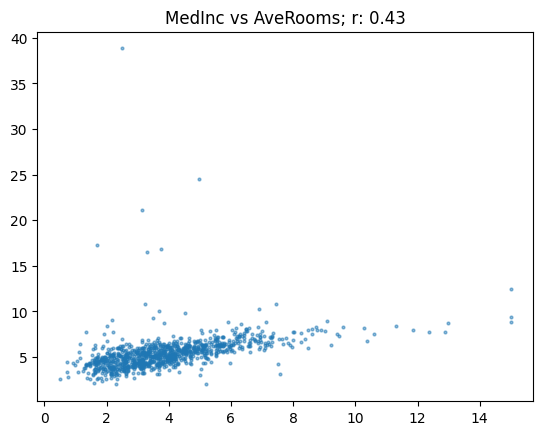

In [133]:
show_corr(housing, 'MedInc', 'AveRooms')

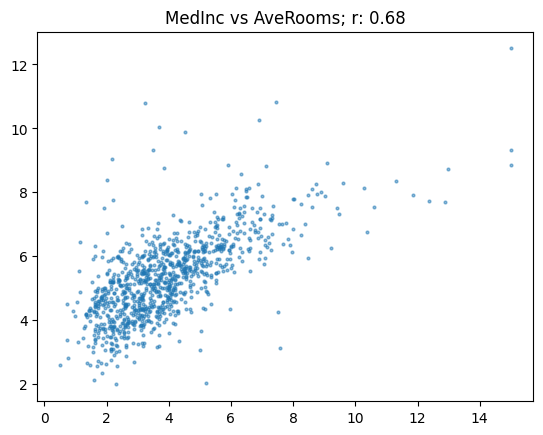

In [136]:
subset = housing[housing.AveRooms<15]
show_corr(subset, 'MedInc', 'AveRooms')

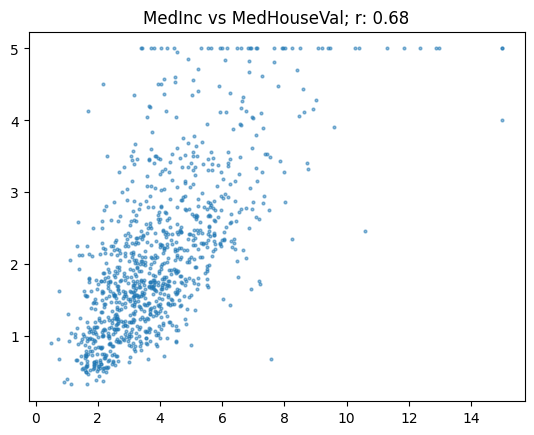

In [140]:
subset = housing[housing.AveRooms<15]
#show_corr(subset, 'MedInc', 'AveOccup4')

show_corr(subset, 'MedInc', 'MedHouseVal')

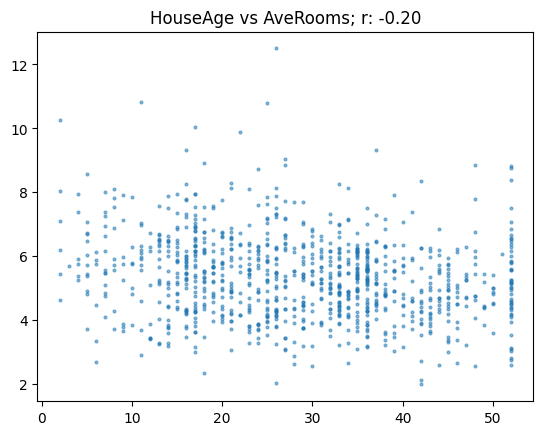

In [141]:
show_corr(subset, 'HouseAge', 'AveRooms')

In [142]:
def corr_d(eval_pred): return {'pearson': corr(*eval_pred)}

In [143]:
from transformers import TrainingArguments,Trainer

In [144]:
bs = 128
epochs = 4

In [145]:
lr = 8e-5

In [150]:
!pip install transformers

args = TrainingArguments(
        'outputs', 
        learning_rate=lr, 
        warmup_ratio=0.1, 
        lr_scheduler_type='cosine', 
        fp16=True,
        evaluation_strategy="epoch", 
        per_device_train_batch_size=bs, 
        per_device_eval_batch_size=bs*2,
        num_train_epochs=epochs,
        weight_decay=0.01,
        report_to='none'
        )

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


TypeError: TrainingArguments.__init__() got an unexpected keyword argument 'evaluation_strategy'